In [1]:
import csv
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.math import multiply
from tensorflow.math import sign
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# from utils import *
from keras_dgl.layers import MultiGraphCNN

In [2]:
from platform import python_version
print("Current Python Version-", python_version())

Current Python Version- 3.9.16


In [3]:
# this function only process vertical openings
def find_edge_WSEN_and_shift(rm_center, rm_dim, edge):
    WSEN = [0,0,0,0]
    h_shift, v_shift = 0.0, 0.0
    edge_cx, edge_cy, edge_cz = (edge[0]+edge[1])/2.0, (edge[2]+edge[3])/2.0, (edge[4]+edge[5])/2.0
    rm_cx, rm_cy, rm_cz = rm_center[0], rm_center[1], rm_center[2]
    rm_dimx, rm_dimy, rm_dimz = rm_dim[0], rm_dim[1], rm_dim[2]
    if edge[0]==edge[1]: #the opening is on west or east walls (on a yz plane)
        h_shift = (edge_cy-rm_cy)/rm_dimy
        v_shift = (edge_cz-rm_cz)/rm_dimz
        if edge[0] >= rm_center[0]:
            WSEN = [0,0,1,0] #east
        else:
            WSEN = [1,0,0,0] #west
    else: #the opening is on north or south walls (on a xz plane)
        h_shift = (edge_cx-rm_cx)/rm_dimx
        v_shift = (edge_cz-rm_cz)/rm_dimz
        if edge[2] >= rm_center[1]:
            WSEN = [0,0,0,1] #north
        else:
            WSEN = [0,1,0,0] #south
    return WSEN, h_shift, v_shift

In [4]:
def Node_and_Edge_Generator(root_folder, index):
    room_csv_file = root_folder + "design_iteration_" + str(index) + "/design_" + str(index) + "_room.csv"
    open_csv_file = root_folder + "design_iteration_" + str(index) + "/design_" + str(index) + "_open.csv"
    
    room_file = open(room_csv_file, "r")
    rooms = list(csv.reader(room_file, delimiter=','))[:-1]
    room_file.close()
    rooms = np.array(rooms).astype(float)
    opening_file = open(open_csv_file, "r")
    openings = list(csv.reader(opening_file, delimiter=','))
    opening_file.close()
    openings = np.array(openings).astype(float)
    
    num_rm = len(rooms)
    room_mx = np.zeros((4+num_rm, 7))
    ext_dimx = max(rooms[:,1])-min(rooms[:,0])
    ext_dimy = max(rooms[:,3])-min(rooms[:,2])
    ext_dimz = max(rooms[:,5])-min(rooms[:,4])
    ext_cx, ext_cy, ext_cz = (max(rooms[:,1])+min(rooms[:,0]))/2.0,(max(rooms[:,3])+min(rooms[:,2]))/2.0, (max(rooms[:,5])+min(rooms[:,4]))/2.0
    rm_centers = []
    rm_dims = []

    room_mx[0,3] = 1 #West
    room_mx[1,4] = 1 #South
    room_mx[2,5] = 1 #East
    room_mx[3,6] = 1 #North
    for i,rm in enumerate(rooms):
        x_dim = rm[1]-rm[0]
        y_dim = rm[3]-rm[2]
        z_dim = rm[5]-rm[4]
        area = x_dim * y_dim
        rm_centers.append([(rm[0]+rm[1])/2.0, (rm[2]+rm[3])/2.0, (rm[4]+rm[5])/2.0])
        rm_dims.append([x_dim, y_dim, z_dim])
        W, S, E, N = 0, 0, 0, 0
        room_mx[i+4,:] = [x_dim, y_dim, area, W, S, E, N]

    edge_mx = np.zeros((4+num_rm, 4+num_rm, 9))
    label_mx = np.zeros((4+num_rm, 4+num_rm))
    for op in openings:
        ind_a, ind_b = int(op[6]), int(op[7])
        #create label matrix based on the opening csv file, which shuold be updated already with in/out information
        # label_mx[ind_a+4, ind_b+4] = 0.0
        label_mx[ind_b+4, ind_a+4] = 1.0
        
        cx, cy, cz = (op[0]+op[1])/2.0, (op[2]+op[3])/2.0, (op[4]+op[5])/2.0
        h_dim = max(np.abs(op[1]-op[0]), np.abs(op[3]-op[2]))
        v_dim = np.abs(op[5]-op[4])
        area = h_dim*v_dim

        WSEN_a = [0,0,0,0]
        h_shift_a, v_shift_a = 0.0, 0.0
        if ind_a == -1: #North, on the south face
            h_shift_a = (cx-ext_cx)/ext_dimx
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,1,0,0]
        elif ind_a == -2: #East, on the west face
            h_shift_a = (cy-ext_cy)/ext_dimy
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [1,0,0,0]
        elif ind_a == -3: #South, on the north face
            h_shift_a = (cx-ext_cx)/ext_dimx
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,0,0,1]
        elif ind_a == -4: #West, on the east face
            h_shift_a = (cy-ext_cy)/ext_dimy
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,0,1,0]
        else:
            rm_center = rm_centers[ind_a]
            rm_dim = rm_dims[ind_a]
            WSEN_a, h_shift_a, v_shift_a = find_edge_WSEN_and_shift(rm_center, rm_dim, op)

        WSEN_b = [0,0,0,0]
        h_shift_b, v_shift_b = 0.0, 0.0
        if ind_b == -1: #North, on the south face
            h_shift_b = (cx-ext_cx)/ext_dimx
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,1,0,0]
        elif ind_b == -2: #East, on the west face
            h_shift_b = (cy-ext_cy)/ext_dimy
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [1,0,0,0]
        elif ind_b == -3: #South, on the north face
            h_shift_b = (cx-ext_cx)/ext_dimx
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,0,0,1]
        elif ind_b == -4: #West, on the east face
            h_shift_b = (cy-ext_cy)/ext_dimy
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,0,1,0]
        else:
            rm_center = rm_centers[ind_b]
            rm_dim = rm_dims[ind_b]
            WSEN_b, h_shift_b, v_shift_b = find_edge_WSEN_and_shift(rm_center, rm_dim, op)

        edge_mx[:, ind_a+4, ind_b+4] = [h_dim, v_dim, area, round(h_shift_a,4), round(v_shift_a,4)] + WSEN_a
        edge_mx[:, ind_b+4, ind_a+4] = [h_dim, v_dim, area, round(h_shift_b,4), round(v_shift_b,4)] + WSEN_b
    return room_mx, edge_mx, label_mx

In [5]:
# root_folder = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
root_folder = "E:/00_Data_Generator/CFD_result_data/"
ind_list = range(2400, 3000)
node = []
edge = []
label = []
for ind in ind_list:
    room_matrix, edge_matrix, label_matrix = Node_and_Edge_Generator(root_folder, ind)
    # edge_matrix_stack = np.reshape(edge_matrix, (edge_matrix.shape[0]*edge_matrix.shape[2], edge_matrix.shape[1]))
    node.append(room_matrix)
    edge.append(edge_matrix)
    label.append(label_matrix)

In [6]:
# GCN_npz_name = "GCN_2400_train_0601.npz"
# np.savez_compressed(GCN_npz_name, np.array(node), np.array(edge), np.array(label))

In [6]:
GCN_npz_name = "GCN_600_test_0602.npz"
np.savez_compressed(GCN_npz_name, np.array(node), np.array(edge), np.array(label))

In [8]:
###################################################################################
###################################################################################
GCN_npz_name = "GCN_2400_train_0601.npz"
data = np.load(GCN_npz_name)
node, edge, label = data['arr_0'], data['arr_1'], data['arr_2']

In [9]:
node[293]

array([[ 0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
       [10.5   ,  6.75  , 70.875 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 5.25  ,  3.5   , 18.375 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 5.25  ,  7.25  , 38.0625,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 2.25  ,  3.75  ,  8.4375,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 3.    ,  3.75  , 11.25  ,  0.    ,  0.    ,  0.    ,  0.    ]])

<AxesSubplot:>

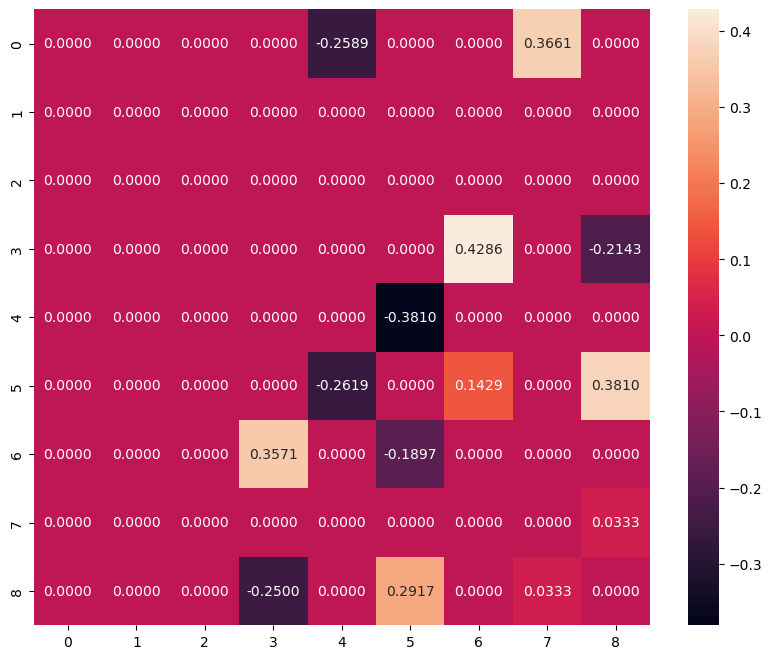

In [10]:
# [h_dim, v_dim, area, h_shift, v_shift, W, S, E, N]
mx = edge[293][3,:,:]
fig= plt.figure(figsize=(10, 8))
sns.heatmap(mx, annot=True, fmt=".4f", square=True)

<AxesSubplot:>

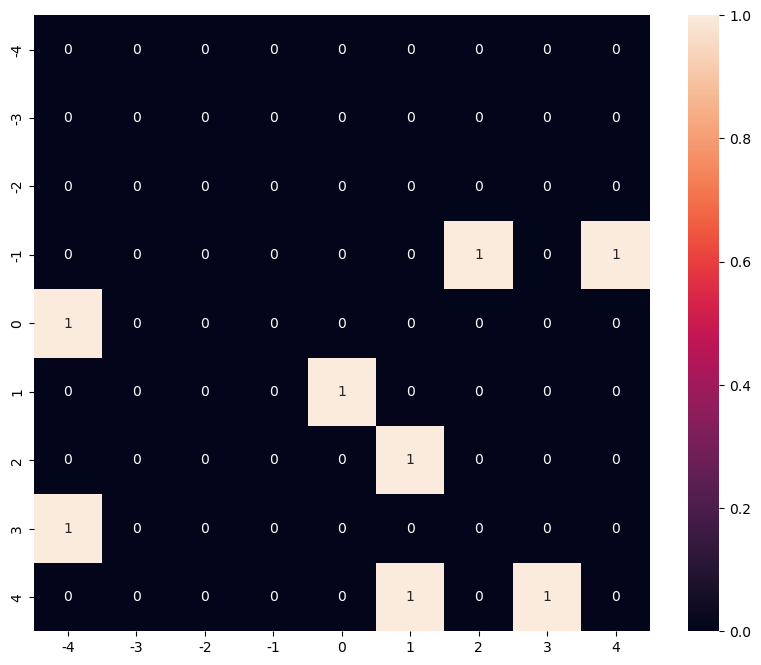

In [11]:
lmx = label[293]
fig = plt.figure(figsize=(10, 8))
sns.heatmap(lmx, annot=True, square=True, xticklabels=range(-4,5), yticklabels=range(-4,5))

In [12]:
# prepare data
A = np.array(edge)
X = np.array(node)
Y = np.array(label)
print("A shape: ", A.shape)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
num_graphs = A.shape[0]
num_edge_features = A.shape[1]
num_graph_nodes = A.shape[2]
print("num_graphs: ", num_graphs)
print("num_edge_features: ", num_edge_features)
print("num_graph_nodes: ", num_graph_nodes)

A shape:  (2400, 9, 9, 9)
X shape:  (2400, 9, 7)
Y shape:  (2400, 9, 9)
num_graphs:  2400
num_edge_features:  9
num_graph_nodes:  9


In [13]:
Y[293]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0.]])